# Atividade 3 de CT-236 2020 

## Instalação

pip install --user igraph

pip install --user numpy

## Imports

In [54]:
import random

import numpy as np
import scipy as sp
import scipy.linalg

import igraph as ig

import matplotlib.pyplot as plt

## Funções Auxiliares

In [55]:
def community_limits(communities):
    begin_end = []
    start = 0
    end = 0
    for size in communities:
        end += size
        begin_end.append((start, end))
        start = end 
    return begin_end


def gn_builder(communities, zin, zout):
    """
    Gerador de redes Girvan-Newman
    """
    total_size = np.sum(communities)
    vertices = range(total_size)
    g = ig.Graph(total_size, directed=False)

    begin_end = community_limits(communities)

    sizes = np.array(communities)
    zin_norm = 2
    total_norm = np.sum(sizes / (total_size - sizes))
    zout_norms = [1 + total_norm - (sizes[i]/(total_size - sizes[i])) \
                    for i in range(len(sizes))]

    for idx in range(len(communities)):
        inside = range(begin_end[idx][0], begin_end[idx][1])
        for vertex in inside:
            # adding edges within community
            eligibles = [target for target in inside if target != vertex]
            chosen = np.random.choice(eligibles, zin)
            pairs = map(lambda target: (vertex, target), chosen)
            pairs = filter(lambda pair: np.random.rand() < 1/zin_norm, pairs)
            g.add_edges(pairs)

            # adding edges to outside community
            eligibles = [target for target in vertices if target not in inside]
            chosen = np.random.choice(eligibles, zout)
            pairs = map(lambda target: (vertex, target), chosen)
            pairs = filter(lambda pair: np.random.rand() < 1/zout_norms[idx], pairs)
            g.add_edges(pairs)

    adjacency = np.array(g.get_adjacency().data)
    new_adj = np.zeros_like(adjacency)
    new_adj[adjacency[:,:] != 0] = 1    # solve multiple edges bewtween i and j 
    return ig.Graph.Adjacency(new_adj.tolist(), mode=ig.ADJ_UNDIRECTED)

def er_builder(n, z):
    return ig.Graph.Erdos_Renyi(n, m=n*z)

def generator(i, communities, zin, zout):
    idx = 0
    for _ in range(i):
        g = gn_builder(communities, zin, zout)
        yield g, idx
        idx += 1

## Exemplos de redes geradas

In [56]:
communities = [32, 32, 32, 32]
zin = 14
zout = 2

color = ['red', 'green', 'blue', 'yellow']

for g, i in generator(10, communities, zin, zout):
    file_name = './images/examples/gn_i{}.png'.format(i)
    layout = g.layout()
    g.vs["color"] = [color[idx//32] for idx in g.vs.indices]
    ig.plot(g, target=file_name, layout=layout)

for i in range(10):
    file_name = './images/examples/er_i{}.png'.format(i)
    g = er_builder(np.sum(communities), (zin + zout) // 2)
    layout = g.layout()
    g.vs["color"] = [color[idx//32] for idx in g.vs.indices]
    ig.plot(g, target=file_name, layout=layout)

Degree Distribution: 
N = 64, mean +- sd: 13.6875 +- 2.6540
[ 8,  9): * (1)
[ 9, 10): *** (3)
[10, 11): *** (3)
[11, 12): ******* (7)
[12, 13): ********* (9)
[13, 14): ******** (8)
[14, 15): ****** (6)
[15, 16): ************ (12)
[16, 17): ****** (6)
[17, 18): ** (2)
[18, 19): ***** (5)
[19, 20): ** (2)

Dendrogram: 


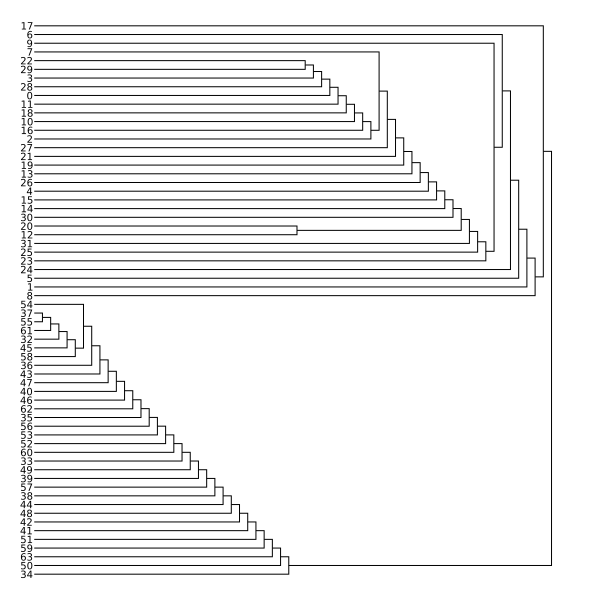

In [57]:
file_name = './images/examples/dendrogram.png'.format(i)

communities = [32, 32]
g = gn_builder(communities, 14, 2)

print('Degree Distribution: ')
print(g.degree_distribution())
print()

print('Dendrogram: ')
dendrogram = g.community_fastgreedy()
ig.plot(dendrogram, target=file_name)

## Análise Espectral

In [58]:
def spectral_analysis(g, normalized=False):
    laplacian = np.matrix(g.laplacian())
    degree = sp.linalg.fractional_matrix_power(np.diag(g.degree()),-0.5)
    normal = degree * laplacian * degree
    if not normalized:
        normal = laplacian
    eig_val, eig_vec = np.linalg.eig(normal)

    idx = eig_val.argsort()
    eig_val = eig_val[idx]
    eig_vec = eig_vec[:,idx]
    return eig_val, eig_vec

In [59]:
sizes = [64, 64]
zin = 14
zout = 2

gn = gn_builder(sizes, zin, zout)
gn_eig_val, gn_eig_vec = spectral_analysis(gn)

er = er_builder(np.sum(sizes), (zin + zout)//2)
er_eig_val, er_eig_vec = spectral_analysis(er)


### Análise: Autovalores de Fiedler

In [60]:
print('Fiedler Eigenvalues: \n')
print('GN: ', gn_eig_val[1])
print('ER: ', er_eig_val[1])

Fiedler Eigenvalues: 

GN:  3.411521851661586
ER:  6.1596379860122425


### Plot: Autovalores

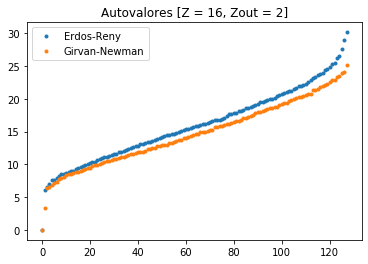

In [61]:
plt.plot(er_eig_val, '.')
plt.plot(gn_eig_val, '.')
plt.title('Autovalores [Z = 16, Zout = 2]')
plt.legend(['Erdos-Reny', 'Girvan-Newman'])
plt.savefig('./images/results/exp0/eigenvalues.png')

### Plot: Autovetor de Fiedler

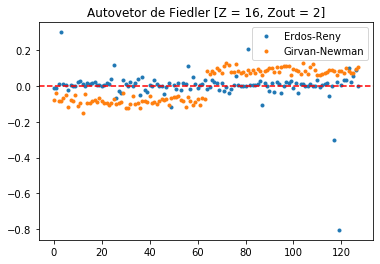

In [62]:
fiedler_er = er_eig_vec[:,1]
fiedler_gn = gn_eig_vec[:,1]

plt.plot(fiedler_er, '.')
plt.plot(fiedler_gn, '.')
plt.axhline(y=0, c='r', ls='--')
plt.title('Autovetor de Fiedler [Z = 16, Zout = 2]')
plt.legend(['Erdos-Reny', 'Girvan-Newman'])
plt.savefig('./images/results/exp0/eigenvectors.png')

## Primeiro Experimento

In [63]:
NUM_SAMPLES = 10

sizes = [64, 64]
limits = community_limits(sizes)
z = 16

accuracies = []
eig_values = []
eig_vectors = []
zins = []
zouts = []

for diff in range(2, z//2):
    zin = (z//2) + diff
    zout = (z//2) - diff
    wrongs = []
    for g, i in generator(NUM_SAMPLES, sizes, zin, zout):
        file_prefix = './images/results/exp1/zin{}_zout{}_i{}'.format(zin, zout, i)
        communities = g.community_leading_eigenvector(clusters=len(sizes))
        ig.plot(communities, target=file_prefix+'_img.png')

        eig_val, eig_vec = spectral_analysis(g)
        eig_values.append(eig_val)
        eig_vectors.append(eig_vec)

        membership = communities.membership
        num_wrong = 0
        for idx in range(len(membership)):
            comm = membership[idx]
            if not(limits[comm][0] <= idx and idx < limits[comm][1]):
                num_wrong += 1
        wrongs.append(num_wrong)
    accuracies.append(1 - (np.mean(wrongs) / len(membership)))
    zins.append(zin)
    zouts.append(zout)
    print('Error for zin={:2d} zout={:2d}: {:g}'.format(zin, zout, np.mean(wrongs) / len(membership)))

total_size = np.sum(sizes)
eig_values = np.reshape(eig_values, (len(zouts), NUM_SAMPLES, total_size))
eig_vectors = np.reshape(eig_vectors, (len(zouts), NUM_SAMPLES, total_size, total_size))

Error for zin=10 zout= 6: 0.473438
Error for zin=11 zout= 5: 0.235156
Error for zin=12 zout= 4: 0.0296875
Error for zin=13 zout= 3: 0.0046875
Error for zin=14 zout= 2: 0
Error for zin=15 zout= 1: 0


### Análise: Autovalores de Fiedler

In [64]:
print('Fiedler Eigenvalues: \n')
for i in range(len(zouts)):
    fiedler = eig_values[i,:,1]
    print('Zout =', zouts[i], '=>', fiedler)
    print('Zout =', zouts[i], '=> Mean =', np.mean(fiedler))
    print()

Fiedler Eigenvalues: 

Zout = 6 => [5.30355234 4.41259147 5.21879375 6.049849   6.2354145  6.88590735
 6.89345895 6.17056064 6.6137184  5.96790118]
Zout = 6 => Mean = 5.975174757387115

Zout = 5 => [6.64894944 5.9354487  6.95814611 4.45810498 6.02615711 5.11914206
 5.70145456 6.16172597 6.19492156 5.77930999]
Zout = 5 => Mean = 5.898336048877399

Zout = 4 => [4.49267976 5.96853801 5.8486352  5.23380643 5.81791782 5.67200617
 6.14068688 5.98932563 6.04296754 5.66839814]
Zout = 4 => Mean = 5.687496157236923

Zout = 3 => [4.06094464 4.77928836 4.56544361 5.08098517 4.58372129 4.86506048
 4.48786316 4.84712301 4.57885675 4.59539672]
Zout = 3 => Mean = 4.6444683200269266

Zout = 2 => [3.60921948 2.93590831 3.18931515 3.37120141 3.37437314 3.18807289
 3.14677218 3.14186869 3.58851846 3.88551429]
Zout = 2 => Mean = 3.3430764000708644

Zout = 1 => [1.78173311 1.81770441 1.73357029 1.70310713 1.80580683 1.56784137
 1.78054388 1.67755734 1.766786   1.76561162]
Zout = 1 => Mean = 1.74002619669737

### Plot: Autovalores

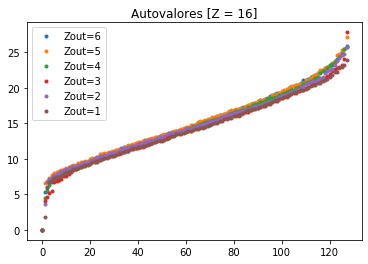

In [65]:
legends = ['Zout={}'.format(zout) for zout in zouts]

for i in range(len(zouts)):    
    plt.plot(eig_values[i, 0, :], '.')

plt.title('Autovalores [Z = 16]')
plt.legend(legends)
plt.savefig('./images/results/exp1/eigenvalues.png')

### Plot: Autovetor de Fiedler

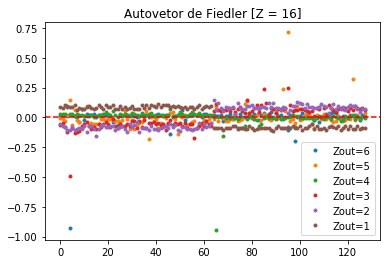

In [66]:
legends = ['Zout={}'.format(zout) for zout in zouts]

for i in range(len(zouts)):  
    fiedler = eig_vectors[i,0,:,1]  
    plt.plot(fiedler, '.')

plt.axhline(y=0, c='r', ls='--')
plt.title('Autovetor de Fiedler [Z = 16]')
plt.legend(legends)
plt.savefig('./images/results/exp1/eigenvectors.png')

### Plot: Acurácia na detecção de comunidade

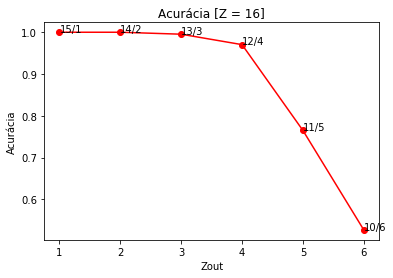

In [67]:
plt.plot(zouts, accuracies, 'ro-')

xys = list(zip(zouts, accuracies))
for i in range(len(zouts)):
    plt.annotate('%d/%d' % (zins[i], zouts[i]), xys[i], textcoords='data')

plt.xlabel('Zout')
plt.ylabel('Acurácia')
plt.title('Acurácia [Z = 16]')
plt.savefig('./images/results/exp1/accuracy.png')

## Segundo Experimento

In [96]:
NUM_SAMPLES = 10

num_vertices = 128
zout = 1
zin = 15

accuracies = []
eig_values = []
eig_vectors = []
nums = []

for num in range(2, 6, 1):
    size = num_vertices // num
    sizes = np.ones((num,), dtype=int) * size
    sizes[-1] += num_vertices - num * size 
    limits = community_limits(sizes)

    wrongs = []
    for g, i in generator(NUM_SAMPLES, sizes, zin, zout):
        file_prefix = './images/results/exp2/zin{}_zout{}_i{}'.format(zin, zout, i)
        communities = g.community_leading_eigenvector(clusters=num)
        ig.plot(communities, target=file_prefix+'_img.png')

        eig_val, eig_vec = spectral_analysis(g)
        eig_values.append(eig_val)
        eig_vectors.append(eig_vec)

        membership = communities.membership
        num_wrong = 0
        for idx in range(len(membership)):
            comm = membership[idx]
            if not(limits[comm][0] <= idx and idx < limits[comm][1]):
                num_wrong += 1
        wrongs.append(num_wrong)

    accuracies.append(1 - (np.mean(wrongs) / len(membership)))
    nums.append(num)


total_size = np.sum(sizes)
eig_values = np.reshape(eig_values, (len(nums), NUM_SAMPLES, total_size))
eig_vectors = np.reshape(eig_vectors, (len(nums), NUM_SAMPLES, total_size, total_size))

### Análise: Autovalores de Fiedler

In [97]:
print('Fiedler Eigenvalues: \n')
for i in range(len(nums)):
    fiedler = eig_values[i,:,1]
    print('#comunidades =', nums[i], '=>', fiedler)
    print('#comunidades =', nums[i], '=> Mean =', np.mean(fiedler))
    print()

Fiedler Eigenvalues: 

#comunidades = 2 => [1.66909703 1.6472842  1.41253709 1.74412279 1.86808187 1.72303792
 1.57090106 1.77455011 1.58751755 1.5942809 ]
#comunidades = 2 => Mean = 1.6591410512179923

#comunidades = 3 => [0.92892657 1.16432401 1.1821022  1.26466256 1.15498679 1.3454351
 1.2621924  1.20590045 1.19692528 1.12240402]
#comunidades = 3 => Mean = 1.1827859376366965

#comunidades = 4 => [1.01834481 1.10193816 1.02519357 1.04484618 0.65722922 0.89724052
 0.84053674 0.99015984 1.06023554 0.77994905]
#comunidades = 4 => Mean = 0.9415673631233343

#comunidades = 5 => [0.85496815 0.58100494 0.8545691  0.66106512 0.70323658 0.7828931
 0.81052691 0.88949481 0.7715694  1.00052273]
#comunidades = 5 => Mean = 0.7909850848971585



### Plot: Autovalores

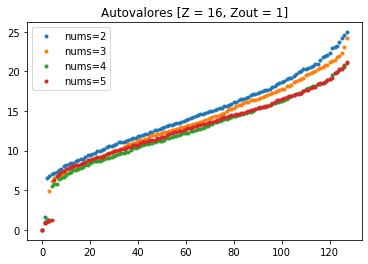

In [98]:
legends = ['nums={}'.format(num) for num in nums]

for i in range(len(nums)):    
    plt.plot(eig_values[i, 0, :], '.')

plt.title('Autovalores [Z = 16, Zout = 1]')
plt.legend(legends)
plt.savefig('./images/results/exp2/eigenvalues.png')

### Plot: Autovetor de Fiedler

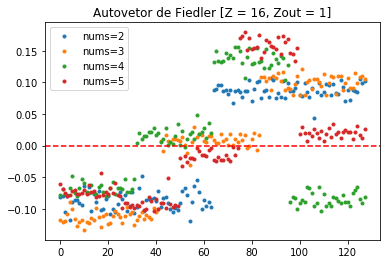

In [99]:
legends = ['nums={}'.format(num) for num in nums]

for i in range(len(nums)):  
    fiedler = eig_vectors[i,0,:,1]  
    plt.plot(fiedler, '.')

plt.axhline(y=0, c='r', ls='--')
plt.title('Autovetor de Fiedler [Z = 16, Zout = 1]')
plt.legend(legends)
plt.savefig('./images/results/exp2/eigenvectors.png')

### Plot: Acurácia na detecção de comunidade

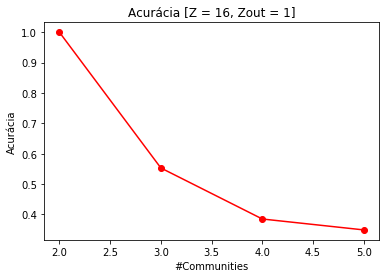

In [100]:
plt.plot(nums, accuracies, 'ro-')
plt.xlabel('#Communities')
plt.ylabel('Acurácia')
plt.title('Acurácia [Z = 16, Zout = 1]')
plt.savefig('./images/results/exp2/accuracy.png')

## Terceiro Experimento

In [73]:
NUM_SAMPLES = 10

num_vertices = 128
z = 16
zouts = 2
zin = z - zout
proportions = np.arange(2.0, 5.5, 1)

accuracies = []
eig_values = []
eig_vectors = []
ratios = []

for ratio in proportions:
    denom = int(1 + ratio)
    sizes = [num_vertices // denom, num_vertices - num_vertices // denom]
    limits = community_limits(sizes)

    wrongs = []
    for g, i in generator(NUM_SAMPLES, sizes, zin, zout):
        file_prefix = './images/results/exp3/zin{}_zout{}_i{}'.format(zin, zout, i)
        communities = g.community_leading_eigenvector(clusters=len(sizes))
        ig.plot(communities, target=file_prefix+'_img.png')

        eig_val, eig_vec = spectral_analysis(g)
        eig_values.append(eig_val)
        eig_vectors.append(eig_vec)

        membership = communities.membership
        num_wrong = 0
        for idx in range(len(membership)):
            comm = membership[idx]
            if not(limits[comm][0] <= idx and idx < limits[comm][1]):
                num_wrong += 1
        wrongs.append(num_wrong)

    accuracies.append(1 - (np.mean(wrongs) / len(membership)))
    ratios.append(ratio)

total_size = num_vertices
eig_values = np.reshape(eig_values, (len(ratios), NUM_SAMPLES, total_size))
eig_vectors = np.reshape(eig_vectors, (len(ratios), NUM_SAMPLES, total_size, total_size))

### Análise: Autovalores de Fiedler

In [74]:
print('Fiedler Eigenvalues: \n')
for i in range(len(ratios)):
    fiedler = eig_values[i,:,1]
    print('Ratio =', ratios[i], '=>', fiedler)
    print('Ratio =', ratios[i], '=> Mean =', np.mean(fiedler))
    print()

Fiedler Eigenvalues: 

Ratio = 2.0 => [2.065737   2.19216093 2.05153994 2.5351245  2.24242344 1.97430623
 2.32282236 2.1287326  2.39771815 2.14118527]
Ratio = 2.0 => Mean = 2.205175044098315

Ratio = 3.0 => [2.91975005 2.88693871 3.35558774 2.94006196 2.87758999 2.87370559
 3.24916353 2.46656768 3.12961943 2.96753491]
Ratio = 3.0 => Mean = 2.9666519578430797

Ratio = 4.0 => [3.8423412  3.60624293 3.93080882 3.63091182 3.86133223 3.84848598
 3.94734033 4.27341171 3.82142769 4.07282102]
Ratio = 4.0 => Mean = 3.8835123721020013

Ratio = 5.0 => [4.85430305 4.7170335  5.06283198 4.6517728  4.25171118 4.07558126
 4.24034152 4.77968615 4.83603745 4.34165749]
Ratio = 5.0 => Mean = 4.581095638937114



### Plot: Autovalores

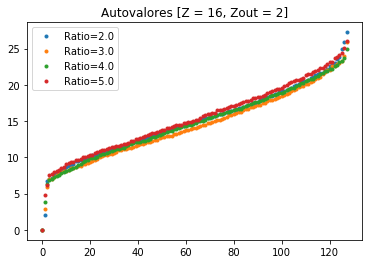

In [75]:
legends = ['Ratio={}'.format(ratio) for ratio in ratios]

for i in range(len(ratios)):    
    plt.plot(eig_values[i, 0, :], '.')

plt.title('Autovalores [Z = 16, Zout = 2]')
plt.legend(legends)
plt.savefig('./images/results/exp3/eigenvalues.png')

### Plot: Autovetor de Fiedler

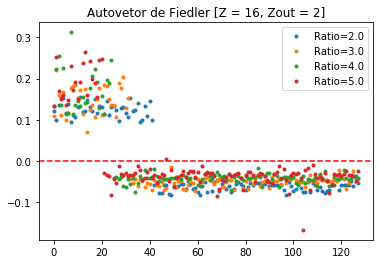

In [76]:
legends = ['Ratio={}'.format(ratio) for ratio in ratios]

for i in range(len(ratios)):  
    fiedler = eig_vectors[i,0,:,1]  
    plt.plot(fiedler, '.')

plt.axhline(y=0, c='r', ls='--')
plt.title('Autovetor de Fiedler [Z = 16, Zout = 2]')
plt.legend(legends)
plt.savefig('./images/results/exp3/eigenvectors.png')

### Plot: Acurácia na detecção de comunidade

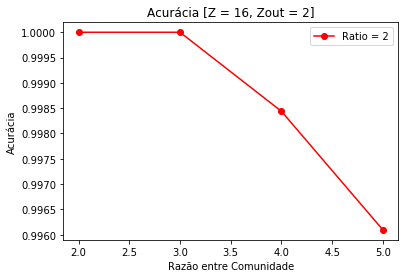

In [77]:
plt.plot(ratios, accuracies, 'ro-')
plt.xlabel('Razão entre Comunidade')
plt.ylabel('Acurácia')
plt.title('Acurácia [Z = 16, Zout = 2]')
plt.legend(['Ratio = 2', 'Ratio = 3', 'Ratio = 4'])
plt.savefig('./images/results/exp3/accuracy.png')

## Quarto Experimento

### Importando redes

In [78]:
gs = []

g = ig.Graph.Read_Edgelist('./datasets/lastfm_asia_edges.edges', directed=False)
g.simplify()
print(g.summary())
gs.append(g)

g = ig.Graph.Read_Edgelist('./datasets/facebook.edges', directed=False)
g.simplify()
print(g.summary())
gs.append(g)

IGRAPH U--- 7624 27806 -- 
IGRAPH U--- 4039 84243 -- 


### Processando

In [79]:
import time

for i in range(len(gs)):
    g = gs[i]
    print('\nNETWORK: {}\n'.format(i))


    # Fiedler
    print('Fiedler started')
    start = time.time()
    fiedler = g.community_leading_eigenvector()
    print('Time: ', time.time() - start)
    print('Modularity: ', fiedler.modularity)

    fiedler_g = fiedler.cluster_graph()
    ig.plot(fiedler_g, target='./images/results/bench/i{}_fiedler.png'.format(i))
    print('Fiedler finished\n')

    # Greedy
    print('Greedy started')
    start = time.time()
    greedy = g.community_fastgreedy().as_clustering()
    print('Time: ', time.time() - start)
    print('Modularity: ', greedy.modularity)

    greedy_g = fiedler.cluster_graph()
    ig.plot(greedy_g, target='./images/results/bench/i{}_greedy.png'.format(i))
    print('Greedy finished\n')



NETWORK: 0

Fiedler started
Time:  2.668313980102539
Modularity:  0.7450386461444217
Fiedler finished

Greedy started
Time:  0.28032755851745605
Modularity:  0.7966054632778499
Greedy finished


NETWORK: 1

Fiedler started
Time:  2.238320827484131
Modularity:  0.8241127441608489
Fiedler finished

Greedy started
Time:  0.1556408405303955
Modularity:  0.7855324746101787
Greedy finished

